In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D,Conv2D
from keras.layers import Activation,Dropout,Flatten,Dense,MaxPooling2D,BatchNormalization
from keras.applications import ResNet50
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras.models import Model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications

In [4]:
X_train = "../input/train/train"
Y_train = "../input/test/test"

In [5]:
len(X_train)

20

In [6]:
train_data = pd.read_csv('../input/train.csv',low_memory=False)
train_data['has_cactus'].value_counts()
train_data.has_cactus = train_data.has_cactus.astype(str)

validation_split = 0.8
msk = np.random.rand(len(train_data)) < validation_split
train = train_data[msk]
validation = train_data[~msk]

In [7]:
print("The number of rows in test set is %d"%(len(os.listdir('../input/test/test'))))
print("The number of rows in train set is %d"%(len(os.listdir('../input/train/train'))))

The number of rows in test set is 4000
The number of rows in train set is 17500


In [8]:
#datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 32
num_classes = 2
target_size=(32,32)
input_shape=(32,32,3)

In [9]:
train_datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,vertical_flip=False,
        fill_mode='nearest')

In [10]:
valid_datagen = ImageDataGenerator(rescale=1/.255)

In [11]:
train_generator=train_datagen.flow_from_dataframe(train,directory=X_train,x_col='id',y_col='has_cactus',
                                           class_mode='binary',batch_size=batch_size,target_size=target_size)

valid_generator = valid_datagen.flow_from_dataframe(validation,directory=X_train,x_col='id',y_col='has_cactus',
                                           class_mode='binary',batch_size=batch_size,target_size=target_size)

Found 14031 validated image filenames belonging to 2 classes.
Found 3469 validated image filenames belonging to 2 classes.


In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weights

array([1.98739377, 0.66807923])

In [13]:
print(train_generator.n)
print(valid_generator.n)

14031
3469


In [14]:
from keras.applications import VGG16

In [15]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
print('Model Loaded')

base_model.trainable = False


58892288/58889256 [==============================] - 1s 0us/step
Model Loaded


In [16]:
top_model = Sequential()
top_model.add(base_model)
top_model.add(Flatten())
top_model.add(Dense(1024))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.4))
#top_model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
top_model.add(Dense(1))
top_model.add(Activation('sigmoid'))

model=top_model


#optimizer = optimizers.SGD(lr=0.01,decay=1e-6,momentum=0.9,nesterov=True)
#optimizer= optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

model.compile(optimizer=Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [17]:
file_path="weights.best.hdf5"

checkpoint = ModelCheckpoint(file_path,monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=15)
#ReduceLROnPlateau = ReduceLROnPlateau(patience=10, verbose=1)

callbacks_list = [checkpoint, early] 

history = model.fit_generator(train_generator,
                    steps_per_epoch= train_generator.n//batch_size,
                    epochs=100 , verbose=2,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//batch_size,callbacks=callbacks_list,
                    class_weight=class_weights)

Epoch 1/100
 - 40s - loss: 2.1743 - acc: 0.7393 - val_loss: 0.9275 - val_acc: 0.9170

Epoch 00001: val_loss improved from inf to 0.92746, saving model to weights.best.hdf5
Epoch 2/100
 - 17s - loss: 0.9347 - acc: 0.8746 - val_loss: 0.7374 - val_acc: 0.9369

Epoch 00002: val_loss improved from 0.92746 to 0.73743, saving model to weights.best.hdf5
Epoch 3/100
 - 17s - loss: 0.7816 - acc: 0.8971 - val_loss: 0.6591 - val_acc: 0.9465

Epoch 00003: val_loss improved from 0.73743 to 0.65907, saving model to weights.best.hdf5
Epoch 4/100
 - 17s - loss: 0.7118 - acc: 0.9107 - val_loss: 0.6202 - val_acc: 0.9514

Epoch 00004: val_loss improved from 0.65907 to 0.62017, saving model to weights.best.hdf5
Epoch 5/100
 - 17s - loss: 0.6477 - acc: 0.9175 - val_loss: 0.5719 - val_acc: 0.9534

Epoch 00005: val_loss improved from 0.62017 to 0.57191, saving model to weights.best.hdf5
Epoch 6/100
 - 17s - loss: 0.5800 - acc: 0.9219 - val_loss: 0.5561 - val_acc: 0.9549

Epoch 00006: val_loss improved from 0.


Epoch 00053: val_loss did not improve from 0.23397
Epoch 54/100
 - 17s - loss: 0.1938 - acc: 0.9585 - val_loss: 0.2054 - val_acc: 0.9796

Epoch 00054: val_loss improved from 0.23397 to 0.20539, saving model to weights.best.hdf5
Epoch 55/100
 - 17s - loss: 0.1941 - acc: 0.9593 - val_loss: 0.2766 - val_acc: 0.9741

Epoch 00055: val_loss did not improve from 0.20539
Epoch 56/100
 - 16s - loss: 0.1889 - acc: 0.9590 - val_loss: 0.2474 - val_acc: 0.9782

Epoch 00056: val_loss did not improve from 0.20539
Epoch 57/100
 - 16s - loss: 0.1800 - acc: 0.9579 - val_loss: 0.3072 - val_acc: 0.9715

Epoch 00057: val_loss did not improve from 0.20539
Epoch 58/100
 - 16s - loss: 0.1853 - acc: 0.9600 - val_loss: 0.2287 - val_acc: 0.9788

Epoch 00058: val_loss did not improve from 0.20539
Epoch 59/100
 - 16s - loss: 0.1758 - acc: 0.9601 - val_loss: 0.2234 - val_acc: 0.9791

Epoch 00059: val_loss did not improve from 0.20539
Epoch 60/100
 - 16s - loss: 0.1806 - acc: 0.9593 - val_loss: 0.2520 - val_acc: 0.

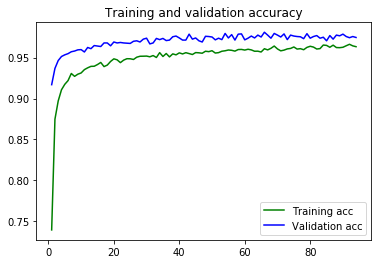

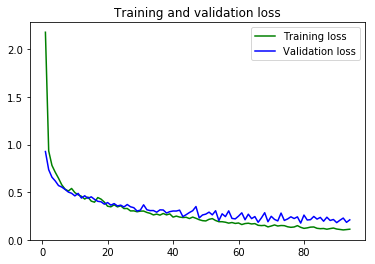

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
model.load_weights("weights.best.hdf5")
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])

In [22]:
import os,cv2
import json
from IPython.display import Image
from keras.preprocessing import image
from tqdm import tqdm, tqdm_notebook
un_test_img=[]
count=0
for i in os.listdir("../input/test/test/"):
    un_test_img.append(i)
    count+=1
un_test_image=[]
for i in tqdm(range(count)):
    img = image.load_img('../input/test/test/'+un_test_img[i], target_size=target_size, grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    un_test_image.append(img)
un_test_img_array = np.array(un_test_image)

100%|██████████| 4000/4000 [00:02<00:00, 1817.02it/s]


In [23]:
output = model.predict_classes(un_test_img_array)

In [24]:
submission_save = pd.DataFrame()
submission_save['id'] = un_test_img
submission_save['has_cactus'] = output
submission_save.to_csv('submission.csv', header=True, index=False)